In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime as dt
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
import datetime
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import accuracy_score, mean_squared_error

In [99]:
df = pd.read_csv("AMZN.csv", delimiter = ',',usecols = ['Date', 'Open', 'High', 'Low', 'Close'] )

In [100]:
df.head()

,Date,Open,High,Low,Close
0,2009-04-17,76.779999,78.720001,75.879997,78.050003
1,2009-04-20,78.440002,79.790001,76.830002,77.570000
2,2009-04-21,77.330002,79.099998,77.290001,78.739998
3,2009-04-22,78.169998,82.180000,77.809998,79.199997
4,2009-04-23,81.330002,82.059998,79.080002,80.610001


In [101]:
df.tail(5)

,Date,Open,High,Low,Close
2513,2019-04-11,1848.699951,1849.949951,1840.310059,1844.069946
2514,2019-04-12,1848.400024,1851.500000,1841.300049,1843.060059
2515,2019-04-15,1842.000000,1846.849976,1818.900024,1844.869995
2516,2019-04-16,1851.349976,1869.770020,1848.000000,1863.040039
2517,2019-04-17,1872.989990,1876.473022,1860.805054,1862.650024


In [102]:
df.isnull().values.any()

False

In [103]:
df['Date'] = pd.to_datetime(df['Date'])

In [104]:
df.head()

,Date,Open,High,Low,Close
0,2009-04-17,76.779999,78.720001,75.879997,78.050003
1,2009-04-20,78.440002,79.790001,76.830002,77.570000
2,2009-04-21,77.330002,79.099998,77.290001,78.739998
3,2009-04-22,78.169998,82.180000,77.809998,79.199997
4,2009-04-23,81.330002,82.059998,79.080002,80.610001


In [105]:
df.tail(5)

,Date,Open,High,Low,Close
2513,2019-04-11,1848.699951,1849.949951,1840.310059,1844.069946
2514,2019-04-12,1848.400024,1851.500000,1841.300049,1843.060059
2515,2019-04-15,1842.000000,1846.849976,1818.900024,1844.869995
2516,2019-04-16,1851.349976,1869.770020,1848.000000,1863.040039
2517,2019-04-17,1872.989990,1876.473022,1860.805054,1862.650024


In [106]:
df.shape

(2518, 5)

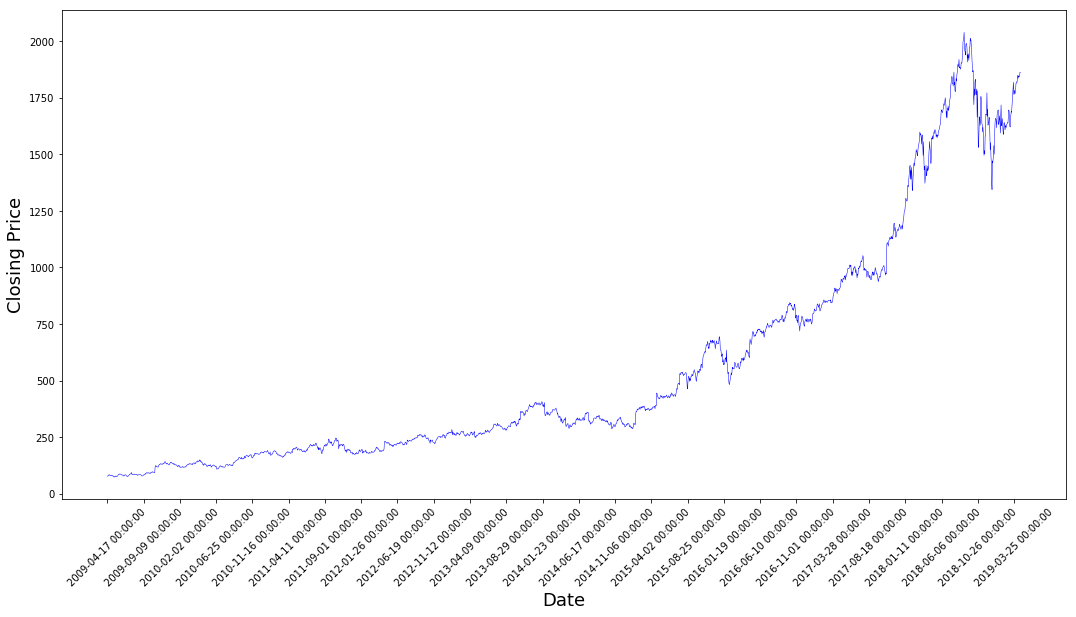

In [107]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), df['Close'], linewidth = 0.5, color = 'blue')
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price',fontsize=18)
plt.show()

In [108]:
final = df['Close']

In [109]:
#storing Close values in an array
stock = df['Close'].values

In [110]:
#making stock 2D
stock = stock.reshape(-1,1)

In [111]:
stock.shape

(2518, 1)

In [112]:
#scaling stock values in range (0,1) for normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_stock = scaler.fit_transform(stock)

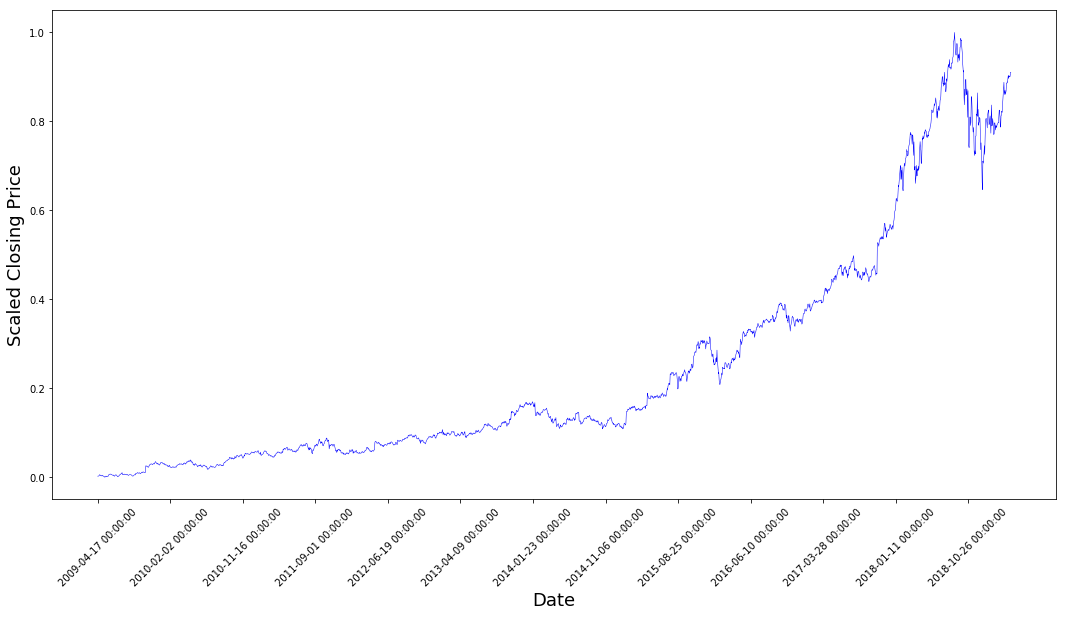

In [113]:
plt.figure(figsize = (18,9))
plt.plot(range(scaled_stock.shape[0]), scaled_stock, linewidth = 0.5, color = 'blue')
plt.xticks(range(0,scaled_stock.shape[0],200), df['Date'].loc[::200], rotation = '45')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Scaled Closing Price',fontsize=18)
plt.show()

In [114]:
#finding split position for dividing data into training and test sets
split = int(len(scaled_stock) * 0.80)

In [115]:
#splitting train and test sets
train = scaled_stock[0:split, :]
test = scaled_stock[split:, :]

In [116]:
train.shape

(2014, 1)

In [117]:
test.shape

(504, 1)

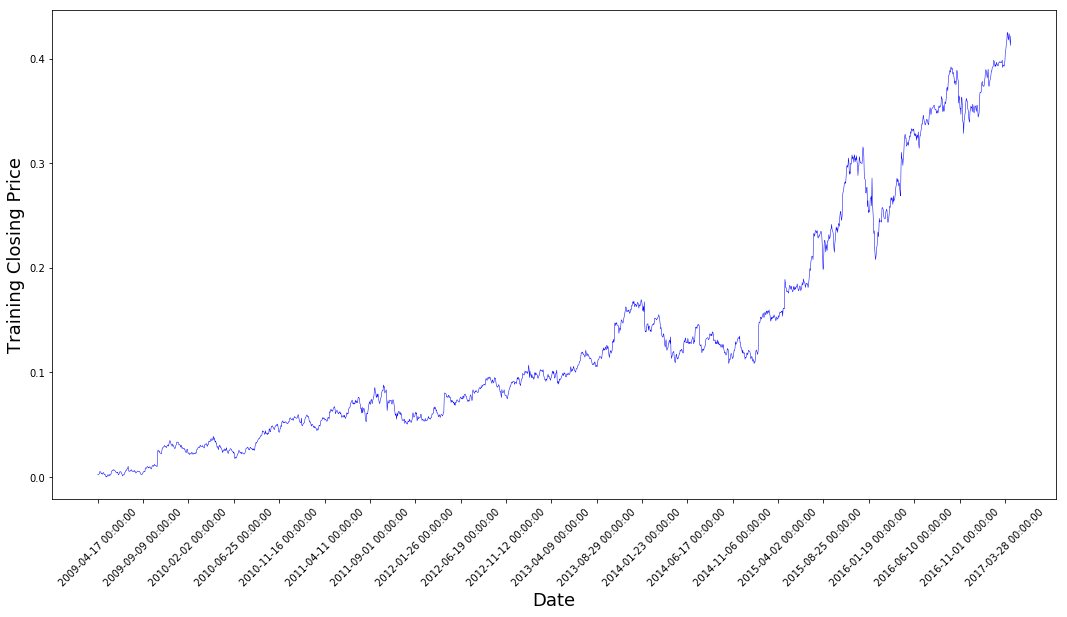

In [118]:
plt.figure(figsize = (18,9))
plt.plot(range(train.shape[0]), train, linewidth = 0.5, color = 'blue')
plt.xticks(range(0,train.shape[0],100), df['Date'].loc[:split:100], rotation = '45')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Training Closing Price',fontsize=18)
plt.show()

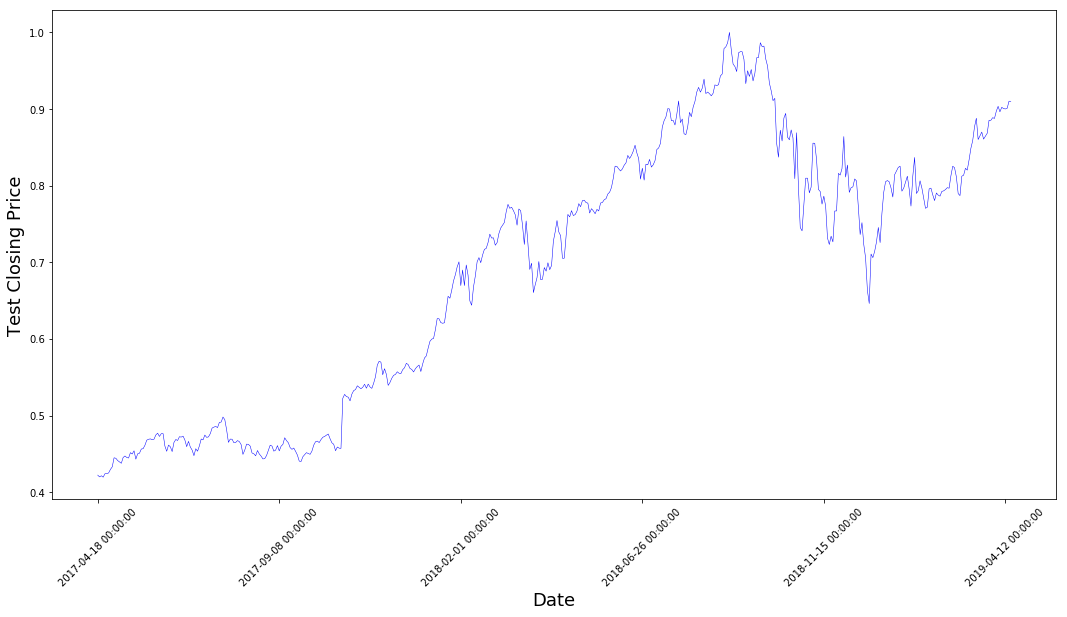

In [119]:
plt.figure(figsize = (18,9))
plt.plot(range(test.shape[0]), test, linewidth = 0.5, color = 'blue')
plt.xticks(range(0,test.shape[0],100), df['Date'].loc[split::100], rotation = '45')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Test Closing Price',fontsize=18)
plt.show()

In [129]:
#sampling training data
#introducing timesteps of 60
def sampling(data, past):
    X, Y = [], []
    for i in range(0, len(data)-past):
        X.append(data[i:i+past,0])
        Y.append(data[i+past,0])
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [130]:
X_train, Y_train = sampling(train, 60)
X_test, Y_test = sampling(test, 60)

In [131]:
X_train.shape

(1954, 60)

In [132]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [133]:
X_train.shape

(1954, 60, 1)

In [134]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [135]:
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1],1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [136]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 100, batch_size = 30, verbose = 2)

Train on 1954 samples, validate on 444 samples
Epoch 1/100
 - 7s - loss: 0.0077 - val_loss: 0.0018
Epoch 2/100
 - 7s - loss: 1.6927e-04 - val_loss: 0.0028
Epoch 3/100
 - 6s - loss: 1.0425e-04 - val_loss: 0.0012
Epoch 4/100
 - 6s - loss: 8.0833e-05 - val_loss: 0.0020
Epoch 5/100
 - 5s - loss: 6.8717e-05 - val_loss: 0.0043
Epoch 6/100
 - 4s - loss: 6.4611e-05 - val_loss: 0.0058
Epoch 7/100
 - 5s - loss: 5.9784e-05 - val_loss: 0.0063
Epoch 8/100
 - 5s - loss: 5.8711e-05 - val_loss: 0.0075
Epoch 9/100
 - 5s - loss: 5.8860e-05 - val_loss: 0.0080
Epoch 10/100
 - 5s - loss: 5.8041e-05 - val_loss: 0.0065
Epoch 11/100
 - 6s - loss: 5.7724e-05 - val_loss: 0.0066
Epoch 12/100
 - 7s - loss: 5.4410e-05 - val_loss: 0.0040
Epoch 13/100
 - 5s - loss: 5.5132e-05 - val_loss: 0.0038
Epoch 14/100
 - 5s - loss: 5.4597e-05 - val_loss: 0.0051
Epoch 15/100
 - 6s - loss: 5.1537e-05 - val_loss: 0.0043
Epoch 16/100
 - 7s - loss: 5.3492e-05 - val_loss: 0.0039
Epoch 17/100
 - 7s - loss: 5.2010e-05 - val_loss: 0.00

In [138]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [139]:
testPredict = model.predict(X_test)

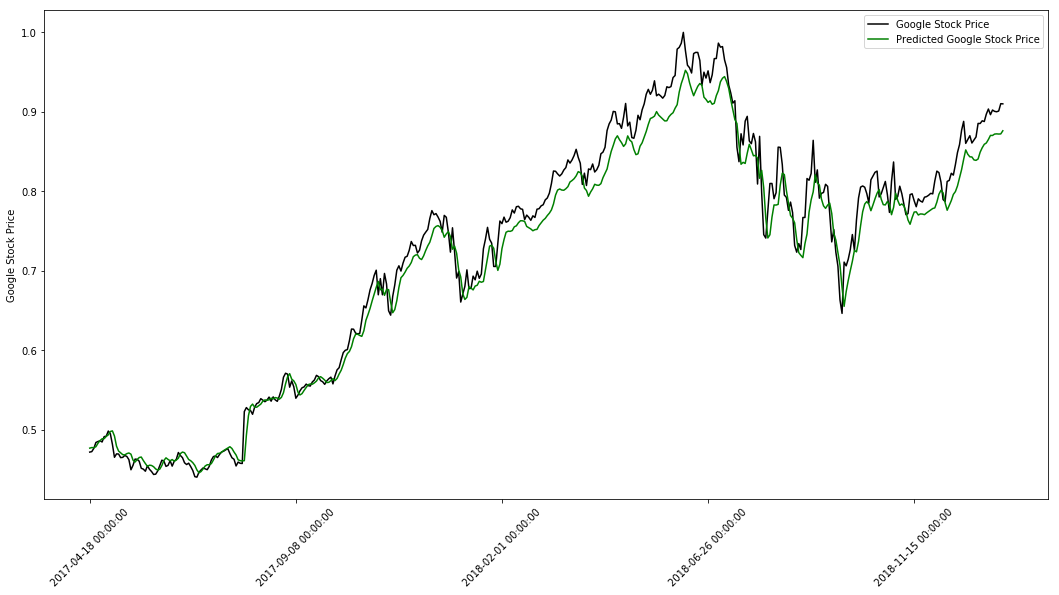

In [140]:
plt.figure(figsize = (18,9))
plt.plot(Y_test, color = 'black', label = 'Google Stock Price')
plt.plot(testPredict, color = 'green', label = 'Predicted Google Stock Price')
plt.xticks(range(0,Y_test.shape[0],100), df['Date'].loc[split::100], rotation=45)
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

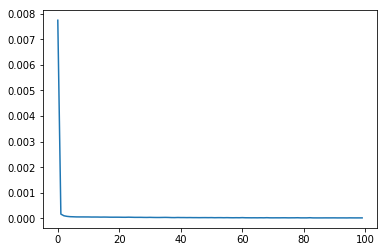

In [141]:
plt.plot(history.history['loss'])

In [142]:
X_test.shape

(444, 60, 1)

In [143]:
print(mean_squared_error(Y_test, testPredict))

0.0006443807604672863


In [144]:
predicted = scaler.inverse_transform(testPredict)

In [145]:
predicted.shape

(444, 1)

In [146]:
actual = stock[split+60:]

In [147]:
actual.shape

(444, 1)

In [148]:
rms=np.sqrt(np.mean(np.power((np.array(actual)-np.array(predicted)),2)))

In [149]:
rms

49.90392574578511

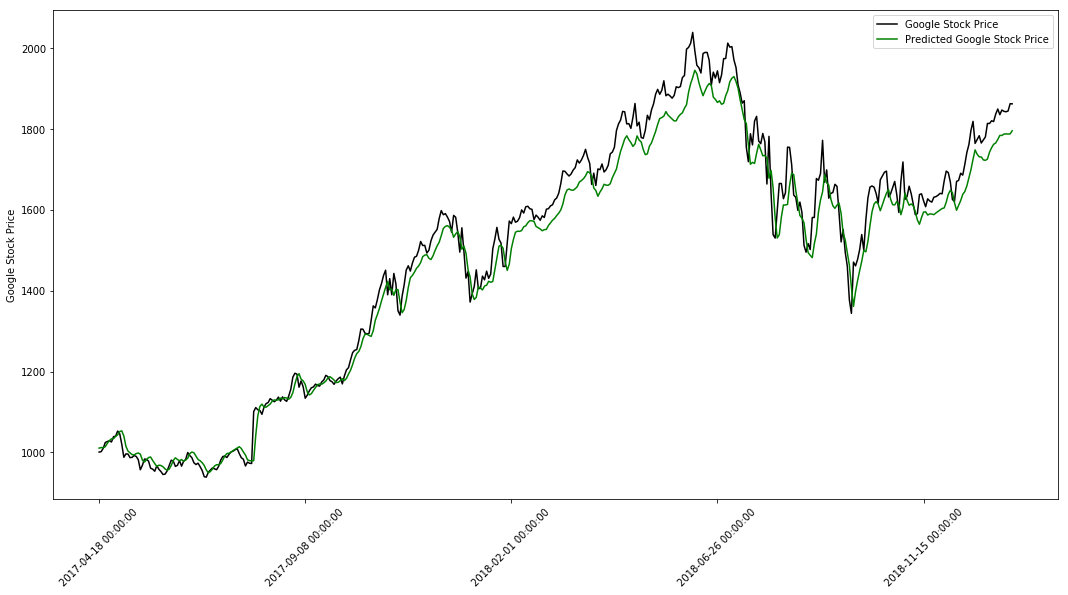

In [150]:
plt.figure(figsize = (18,9))
plt.plot(actual, color = 'black', label = 'Google Stock Price')
plt.plot(predicted, color = 'green', label = 'Predicted Google Stock Price')
plt.xticks(range(0,Y_test.shape[0],100), df['Date'].loc[split::100], rotation=45)
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()